In [1]:
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
# prompt: mount folder from google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
###########################################
# Original Loading and Visualization Functions
###########################################

In [4]:
def load_npz_file(npz_path):
    """
    Load an NPZ file containing medical image and label data.

    Parameters:
    - npz_path: str, path to the NPZ file

    Returns:
    - image: np.ndarray, the image data
    - label: np.ndarray, the label data
    """
    data = np.load(npz_path)
    image = data['image']
    label = data['label']
    return image, label

In [5]:
def visualize_data(image, label, output_dir, filename):
    """
    Visualize and save the image and label side by side.

    Parameters:
    - image: np.ndarray, the medical image
    - label: np.ndarray, the corresponding label
    - output_dir: str, directory to save the visualization
    - filename: str, name of the output visualization file
    """
    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Medical Image')
    axes[0].axis('off')

    # Display the label mask
    axes[1].imshow(label, cmap='jet', alpha=0.7)
    axes[1].set_title('Segmentation Label')
    axes[1].axis('off')

    # Save the visualization
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.close()
    print(f"Visualization saved: {output_path}")

In [6]:
def process_npz_files(npz_dir, output_dir):
    """
    Process all NPZ files in a given directory and visualize their contents.

    Parameters:
    - npz_dir: str, directory containing NPZ files
    - output_dir: str, directory to save visualizations
    """
    npz_files = [f for f in os.listdir(npz_dir) if f.endswith('.npz')]

    if not npz_files:
        print("No NPZ files found in the directory.")
        return

    for npz_file in npz_files:
        npz_path = os.path.join(npz_dir, npz_file)
        image, label = load_npz_file(npz_path)
        visualize_data(image, label, output_dir, npz_file.replace('.npz', '.png'))
        break


In [7]:
###########################################
# Dataset Class: StackedSliceDataset
###########################################

In [8]:
class StackedSliceDataset3D(Dataset):
    """
    Builds a 3-slice (previous, current, next) volume from individual 2D slices.
    Each sample has shape [1, 3, 256, 256] for the image,
    and [3, 256, 256] for the label (repeating the 'current' slice label).
    """
    def __init__(self, npz_dir):
        self.paths = sorted([os.path.join(npz_dir, f) for f in os.listdir(npz_dir) if f.endswith('.npz')])
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        idx_prev = max(0, idx - 1)
        idx_next = min(len(self.paths) - 1, idx + 1)
        def load_img(path):
            return np.load(path)['image']
        prev_img = load_img(self.paths[idx_prev])
        curr_img = load_img(self.paths[idx])
        next_img = load_img(self.paths[idx_next])
        stacked_img = np.expand_dims(np.stack([prev_img, curr_img, next_img], axis=0), axis=0)  # [1, 3, H, W]
        label = np.load(self.paths[idx])['label']
        label_vol = np.repeat(label[np.newaxis, :, :], 3, axis=0)  # [3, H, W]
        return torch.tensor(stacked_img, dtype=torch.float32), torch.tensor(label_vol, dtype=torch.long)

In [9]:
import random
import torchvision.transforms.functional as TF

class AugmentedStackedDataset(StackedSliceDataset3D):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)  # image: [1, 3, H, W], label: [3, H, W]

        # Apply brightness and contrast adjustments to the image only.
        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.2)
            image = TF.adjust_brightness(image, factor)
        if random.random() > 0.5:
            factor = random.uniform(0.8, 1.2)
            image = TF.adjust_contrast(image, factor)

        # Horizontal flip on both image and label.
        if torch.rand(1) > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Rotate image and label.
        if torch.rand(1) > 0.5:
            angle = random.uniform(-5, 5)
            image = TF.rotate(image, angle)
            label = TF.rotate(label.unsqueeze(0).float(), angle, interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        # Affine transformation: translation and scaling (no shear)
        if torch.rand(1) > 0.5:
            angle = 0  # no rotation here
            translate = (random.randint(-5, 5), random.randint(-5, 5))
            scale = random.uniform(0.95, 1.05)
            image = TF.affine(image, angle=angle, translate=translate, scale=scale, shear=0)
            label = TF.affine(label.unsqueeze(0).float(), angle=angle, translate=translate, scale=scale, shear=0,
                              interpolation=TF.InterpolationMode.NEAREST).squeeze(0).long()

        return image, label


In [10]:
###########################################
# Model Definitions: UNet3D & AttentionUNet3D
###########################################

In [11]:
class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = [
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.insert(3, nn.Dropout3d(0.5))
        self.double_conv = nn.Sequential(*layers)
    def forward(self, x):
        return self.double_conv(x)

In [12]:
class Down3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.AvgPool3d(kernel_size=(1, 2, 2)),
            DoubleConv3D(in_channels, out_channels, dropout)
        )
    def forward(self, x):
        return self.pool_conv(x)

In [13]:
class Up3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True)
        self.conv = DoubleConv3D(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffD = x2.size()[2] - x1.size()[2]
        diffH = x2.size()[3] - x1.size()[3]
        diffW = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffW//2, diffW - diffW//2,
                        diffH//2, diffH - diffH//2,
                        diffD//2, diffD - diffD//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [14]:
class OutConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

In [15]:
class UNet3D(nn.Module):
    def __init__(self, n_channels=1, n_classes=8):
        super(UNet3D, self).__init__()
        self.inc = DoubleConv3D(n_channels, 64)
        self.down1 = Down3D(64, 128)
        self.down2 = Down3D(128, 256, dropout=True)
        self.down3 = Down3D(256, 512, dropout=True)
        self.down4 = Down3D(512, 512, dropout=True)
        self.up1 = Up3D(1024, 256)
        self.up2 = Up3D(512, 128)
        self.up3 = Up3D(256, 64)
        self.up4 = Up3D(128, 64)
        self.outc = OutConv3D(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

In [16]:
class LabelTransform3D(nn.Module):
    def __init__(self, n_classes=8):
        super(LabelTransform3D, self).__init__()
        self.down = nn.AvgPool3d(kernel_size=(1, 4, 4))
        self.conv = nn.Sequential(
            DoubleConv3D(n_classes, 64),
            DoubleConv3D(64, 64),
            DoubleConv3D(64, 64),
            DoubleConv3D(64, n_classes)
        )
        self.up = nn.Upsample(scale_factor=(1, 4, 4), mode='trilinear', align_corners=True)
    def forward(self, x):
        return self.up(self.conv(self.down(x)))

In [17]:
class MMWHS_Segmentation(nn.Module):
    def __init__(self, n_channels=1, n_classes=8, use_attention=False):
        super(MMWHS_Segmentation, self).__init__()
        # When use_attention is False, we use the plain UNet3D.
        self.unet = UNet3D(n_channels, n_classes)
        self.label_transform = LabelTransform3D(n_classes)
    def forward(self, x):
        unet_out = self.unet(x)
        transform_out = self.label_transform(unet_out)
        return unet_out * transform_out

In [18]:
###########################################
# Loss Function: Combined Cross-Entropy and Dice Loss
###########################################

In [19]:
def dice_loss(pred, target, smooth=1.0, ignore_index=None):
    pred = F.softmax(pred, dim=1)
    target_onehot = torch.zeros_like(pred).scatter_(1, target.unsqueeze(1), 1)
    if ignore_index is not None:
        mask = (target != ignore_index).unsqueeze(1).float()
        pred *= mask
        target_onehot *= mask
    intersection = (pred * target_onehot).sum(dim=(2,3,4))
    union = pred.sum(dim=(2,3,4)) + target_onehot.sum(dim=(2,3,4))
    return 1 - ((2 * intersection + smooth) / (union + smooth)).mean()

In [20]:
class RobustCombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, num_classes=8, background_weight=3.0, eps=1e-7):
        super(RobustCombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.num_classes = num_classes
        self.eps = eps
        self.background_weight = background_weight
        self.nll_loss = None
    def forward(self, outputs, targets, attn_map=None):
        # Note: Since we're not using attention, attn_map is ignored.
        if self.nll_loss is None:
            device = outputs.device
            weights = torch.ones(self.num_classes, device=device)
            weights[0] = self.background_weight
            self.nll_loss = nn.NLLLoss(weight=weights)
        log_probs = F.log_softmax(outputs, dim=1)
        loss = (1 - self.dice_weight) * self.nll_loss(log_probs, targets)
        if self.dice_weight > 0:
            jaccard_loss = 0
            probs = F.softmax(outputs, dim=1)
            for cls in range(self.num_classes):
                target_mask = (targets == cls).float()
                prob_mask = probs[:, cls]
                intersection = (prob_mask * target_mask).sum()
                union = prob_mask.sum() + target_mask.sum()
                weight = 0.7 if cls == 0 else 1.2
                jaccard = (2. * intersection + self.eps) / (union + self.eps)
                jaccard_loss += weight * (1 - jaccard)
            loss += self.dice_weight * (jaccard_loss / self.num_classes)
        return loss

In [21]:
###########################################
# Validation and Metrics Computation
###########################################

In [22]:
def calculate_confusion_matrix(prediction, ground_truth, num_labels):
    replace_indices = np.vstack((ground_truth.flatten(), prediction.flatten())).T
    confusion_matrix, _ = np.histogramdd(replace_indices,
                                         bins=(num_labels, num_labels),
                                         range=[(0, num_labels), (0, num_labels)])
    return confusion_matrix.astype(np.uint32)

def calculate_iou(confusion_matrix):
    ious = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = tp + fp + fn
        ious.append(float(tp) / denom if denom else 0)
    return ious

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[index, index]
        fp = confusion_matrix[:, index].sum() - tp
        fn = confusion_matrix[index, :].sum() - tp
        denom = 2 * tp + fp + fn
        dices.append(2 * float(tp) / denom if denom else 0)
    return dices

In [23]:
def validate_model(model, criterion, loader, num_classes, device):
    model.eval()
    losses = []
    # Build a full confusion matrix over all classes.
    full_conf_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)  # [B, 8, 3, 256, 256]
            loss = criterion(outputs, masks)
            losses.append(loss.item())
            output_classes = outputs.cpu().numpy().argmax(axis=1)  # [B, 3, 256, 256]
            target_classes = masks.cpu().numpy()  # [B, 3, 256, 256]
            full_conf_matrix += calculate_confusion_matrix(output_classes, target_classes, num_labels=num_classes)

    avg_loss = np.mean(losses)
    ious = calculate_iou(full_conf_matrix)
    dices = calculate_dice(full_conf_matrix)
    # Exclude background (class 0) for averaging.
    conf_matrix_no_bg = full_conf_matrix[1:, 1:]
    ious_no_bg = calculate_iou(conf_matrix_no_bg)
    dices_no_bg = calculate_dice(conf_matrix_no_bg)
    avg_iou_no_bg = np.mean(ious_no_bg)
    avg_dice_no_bg = np.mean(dices_no_bg)

    print(f'Validation Loss: {avg_loss:.4f}')
    print(f'Avg IoU (foreground only): {avg_iou_no_bg:.4f}')
    print(f'Avg Dice (foreground only): {avg_dice_no_bg:.4f}')

    return avg_dice_no_bg, avg_iou_no_bg

import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def compute_metrics_all_classes_and_plot(
    attn_map,
    pred_mask,
    input_center,
    gt_mask,
    orig_size,
    class_names=None
):
    """
    Computes segmentation metrics for all classes (including background) and visualizes:
      - Input slice
      - Ground Truth
      - Prediction
      - Attention rollout
      - Overlay (input + attention)

    Also adds a legend below the plots that shows the class names and their corresponding colors.
    """

    # If no class_names provided, fallback
    if class_names is None:
        class_names = ["Background"] + [f"Class {i}" for i in range(1, int(gt_mask.max())+1)]
    num_classes = len(class_names)

    # Create your discrete color list (same length as class_names).
    color_list = [
        "#2F2F2F",  # Background
        "#1f77b4",  # LV
        "#ff7f0e",  # RV
        "#2ca02c",  # LA
        "#d62728",  # RA
        "#9467bd",  # Myocardium
        "#8c564b",  # Aorta
        "#e377c2",  # Pulmonary Artery
    ]
    cmap = mcolors.ListedColormap(color_list[:num_classes])  # slice if you have fewer classes

    # --- Segmentation Metrics ---
    cm = calculate_confusion_matrix(pred_mask, gt_mask, num_labels=num_classes)
    dices = calculate_dice(cm)
    ious = calculate_iou(cm)

    seg_metrics = {}
    for cls_idx in range(num_classes):
        seg_metrics[class_names[cls_idx]] = {
            "Dice": dices[cls_idx],
            "IoU": ious[cls_idx]
        }
    avg_dice = np.mean(dices)

    # # --- Attention Metrics ---
    # entropy_metric = compute_attention_entropy(attn_map)
    # att_overlap_iou = compute_attention_overlap(attn_map, gt_mask, threshold=0.5)

    # Resize the attention map
    attn_tensor = torch.tensor(attn_map[None, None], dtype=torch.float32)
    attn_resized = F.interpolate(attn_tensor, size=orig_size, mode='bilinear', align_corners=True)
    attn_resized = attn_resized.squeeze().numpy()
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min() + 1e-8)

    # Visualization
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))

    axs[0].imshow(input_center, cmap='gray')
    axs[0].set_title("Input", fontsize=14)

    axs[1].imshow(input_center, cmap='gray')
    im1 = axs[1].imshow(gt_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=num_classes-1)
    axs[1].set_title("Ground Truth", fontsize=14)

    axs[2].imshow(input_center, cmap='gray')
    im2 = axs[2].imshow(pred_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=num_classes-1)
    axs[2].set_title("Prediction", fontsize=14)

    axs[3].imshow(attn_resized, cmap='hot')
    axs[3].set_title("Attention Rollout", fontsize=14)

    axs[4].imshow(input_center, cmap='gray')
    axs[4].imshow(attn_resized, cmap='jet', alpha=0.5)
    axs[4].set_title("Overlay (Input + Attention)", fontsize=14)

    for ax in axs:
        ax.axis('off')

    # Reserve space at the bottom for the legend
    plt.tight_layout(rect=[0, 0.15, 1, 1])

    # Create legend
    patches = []
    for i, name in enumerate(class_names):
        patch = mpatches.Patch(color=color_list[i], label=name)
        patches.append(patch)
    plt.figlegend(handles=patches, loc='lower center', ncol=num_classes, labelspacing=0.5, fontsize=12)

    plt.show()

    # print("Segmentation Metrics (per class):")
    # for label, metrics in seg_metrics.items():
    #     print(f"  {label}: Dice={metrics['Dice']:.4f}, IoU={metrics['IoU']:.4f}")
    print(f"\nAverage Dice (all classes): {avg_dice:.4f}")
    # print(f"Attention Entropy: {entropy_metric:.4f}, Attention Overlap IoU: {att_overlap_iou:.4f}")

    return {
        "Segmentation": seg_metrics,
        # "Attention": {"Entropy": entropy_metric, "Overlap IoU": att_overlap_iou}
    }


In [24]:
###########################################
# Training Loop
###########################################

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validation Loss: 1.1018
Avg IoU (foreground only): 0.0548
Avg Dice (foreground only): 0.0950
Epoch [1/25] Train Loss: 1.1690 | Val Dice: 0.0950 | Val IoU: 0.0548
Validation Loss: 1.0753
Avg IoU (foreground only): 0.0460
Avg Dice (foreground only): 0.0783
Epoch [2/25] Train Loss: 1.0841 | Val Dice: 0.0783 | Val IoU: 0.0460
Validation Loss: 1.0330
Avg IoU (foreground only): 0.1313
Avg Dice (foreground only): 0.1837
Epoch [3/25] Train Loss: 1.0497 | Val Dice: 0.1837 | Val IoU: 0.1313
Validation Loss: 1.0165
Avg IoU (foreground only): 0.2090
Avg Dice (foreground only): 0.2888
Epoch [4/25] Train Loss: 1.0213 | Val Dice: 0.2888 | Val IoU: 0.2090
Validation Loss: 0.9742
Avg IoU (foreground only): 0.3621
Avg Dice (foreground only): 0.4562
Epoch [5/25] Train Loss: 0.9919 | Val Dice: 0.4562 | Val IoU: 0.3621
Validation Loss: 0.9594
Avg IoU (foreground only): 0.3450
Avg Dice (foreground only): 0.4329
Epoch [6/25] Train Loss: 0.9660 | Val Dice: 0.4329 | Val IoU: 0.3450
Validation Loss: 0.8967
Avg 

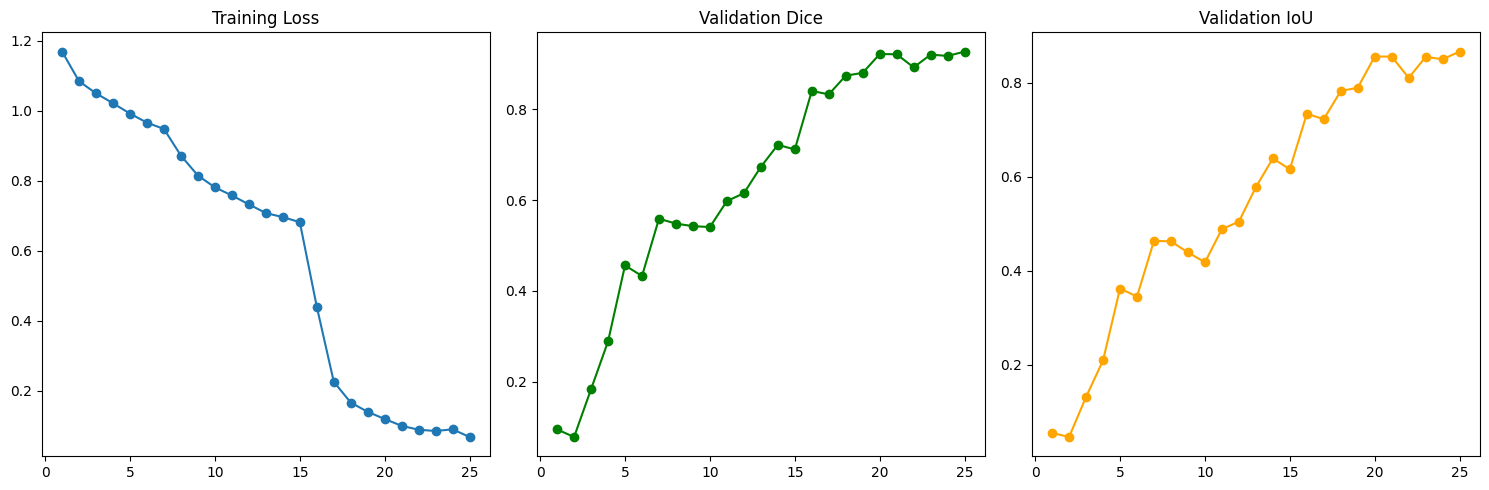

In [25]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Medical Imaging Project/pack/processed_data/mr_256/train/npz'
val_dir   = '/content/drive/MyDrive/Colab Notebooks/Medical Imaging Project/pack/processed_data/mr_256/val/npz'
num_classes = 8
batch_size = 16
learning_rate = 1e-4
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(AugmentedStackedDataset(train_dir), batch_size=batch_size, shuffle=True, num_workers=8)
val_loader   = DataLoader(StackedSliceDataset3D(val_dir), batch_size=batch_size, shuffle=False, num_workers=8)

# Set use_attention=False to use the baseline UNet3D.
use_attention = False

model = MMWHS_Segmentation(n_channels=1, n_classes=num_classes, use_attention=use_attention).to(device)
criterion = RobustCombinedLoss(dice_weight=0.5, num_classes=num_classes, background_weight=3.0, eps=1e-7)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

best_dice = 0
patience = 5
trigger_times = 0
train_losses, val_dices, val_ious = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # [B, 8, 3, 256, 256]
        # Since we're not using attention in this baseline, pass None.
        loss = criterion(outputs, masks, attn_map=None)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)

    dice, iou = validate_model(model, criterion, val_loader, num_classes, device)
    val_dices.append(dice)
    val_ious.append(iou)

    scheduler.step(dice)

    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "best_model.pth")
        trigger_times = 0

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_loss:.4f} | "
          f"Val Dice: {dice:.4f} | Val IoU: {iou:.4f}")


# Plot training and validation metrics
epochs_list = range(1, len(train_losses)+1)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(epochs_list, train_losses, marker='o')
plt.title("Training Loss")
plt.subplot(1,3,2)
plt.plot(epochs_list, val_dices, marker='o', color='green')
plt.title("Validation Dice")
plt.subplot(1,3,3)
plt.plot(epochs_list, val_ious, marker='o', color='orange')
plt.title("Validation IoU")
plt.tight_layout()
plt.show()

Visualizing Validation Samples with Stacked Predictions and Filtered Attention (Baseline Model):
Visualizing Validation Samples:


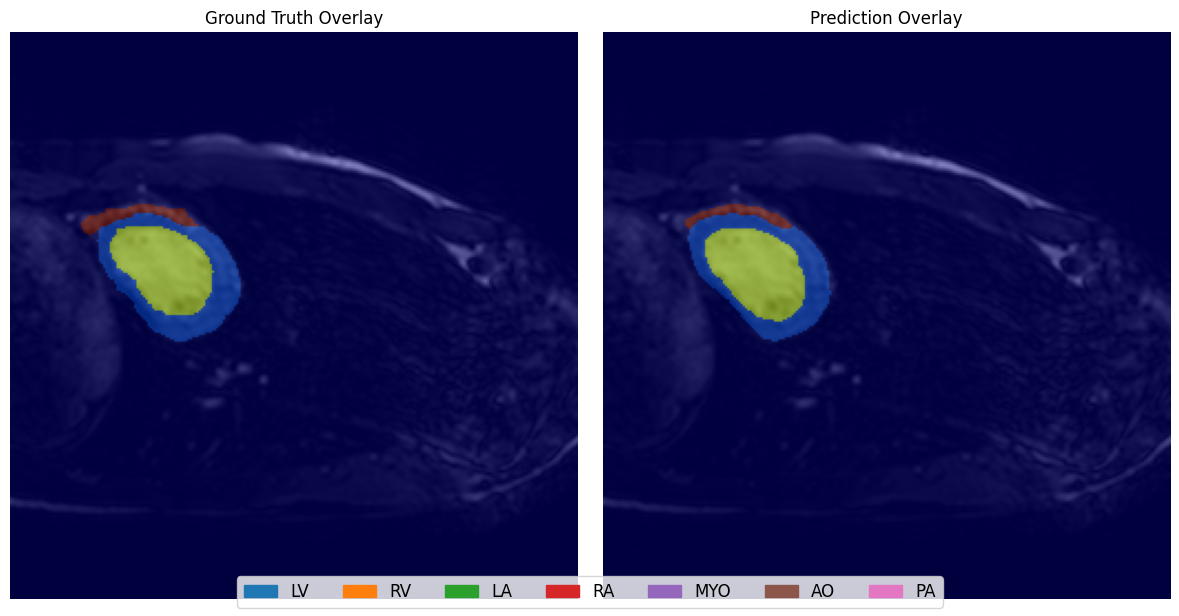

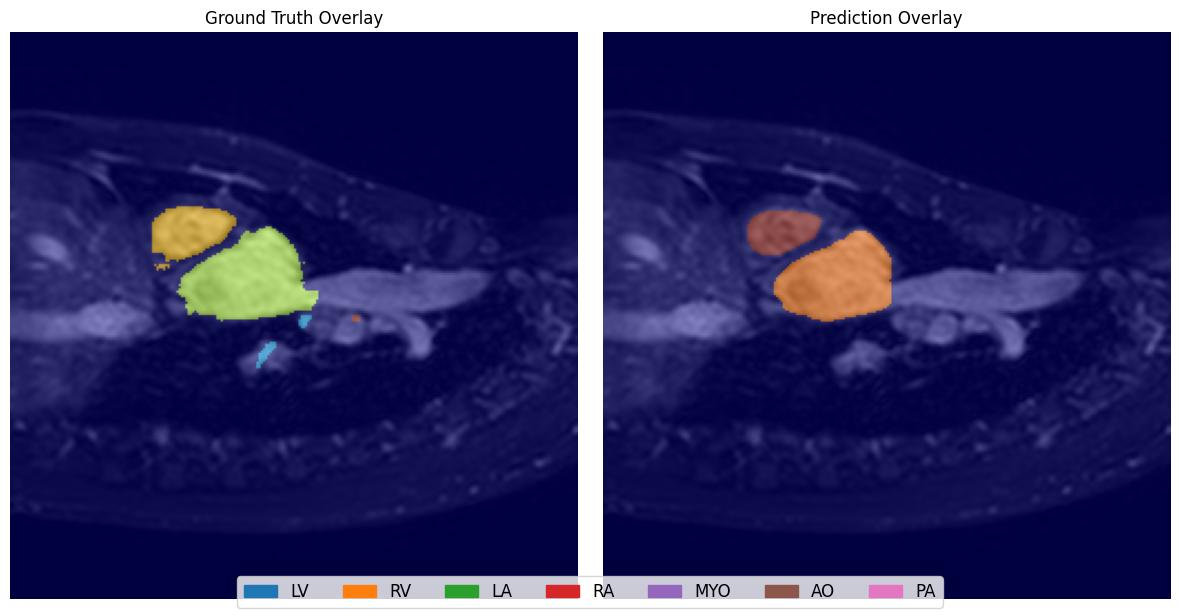

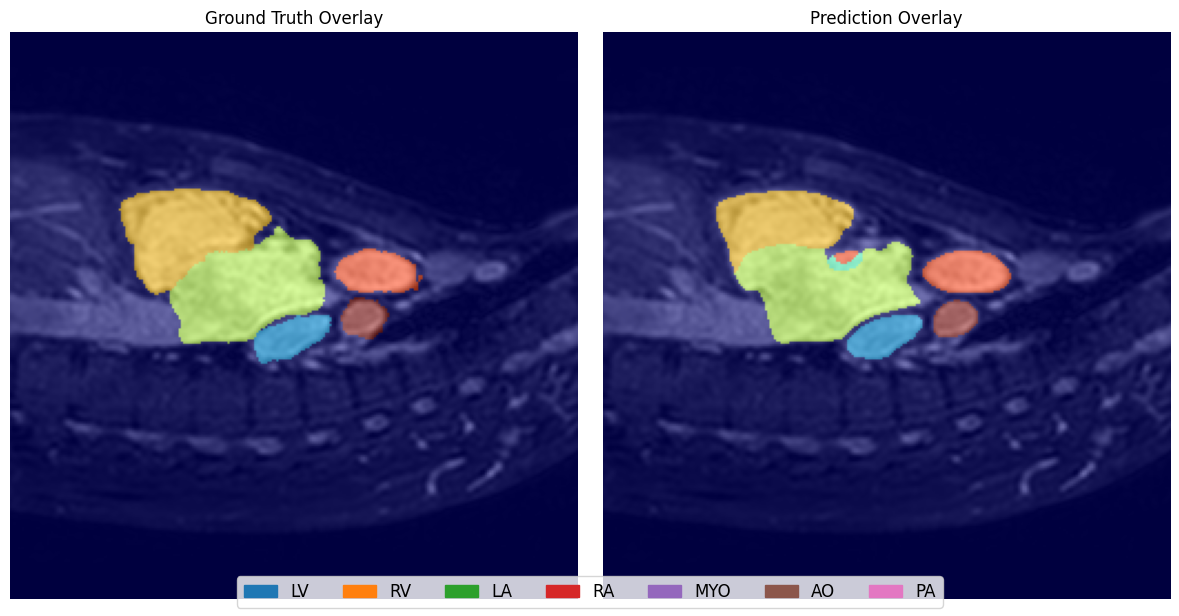

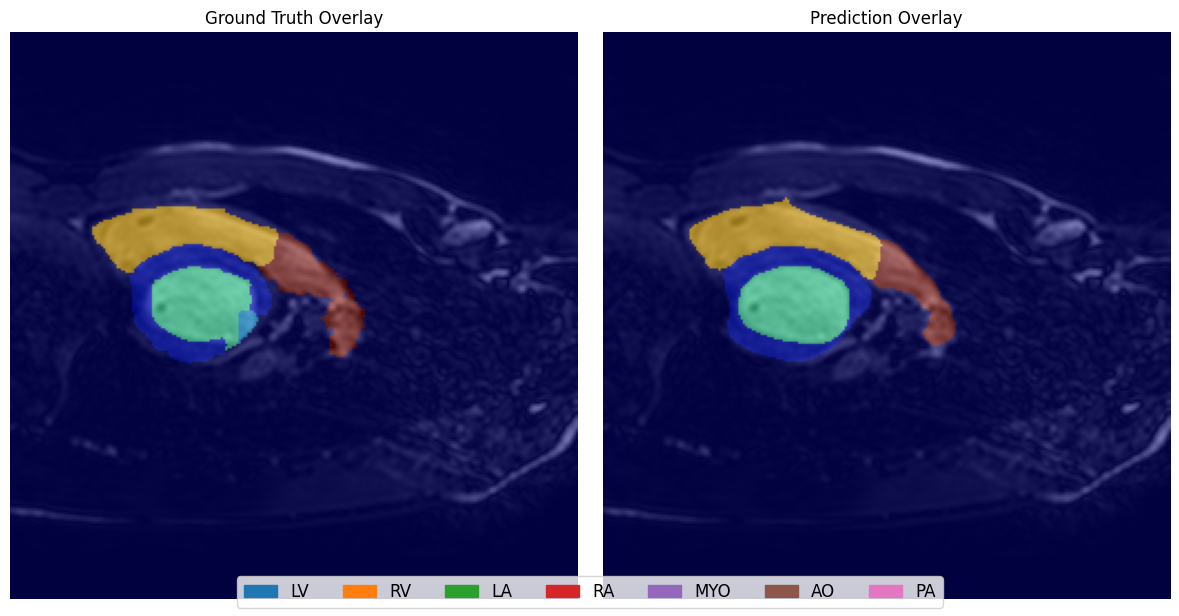

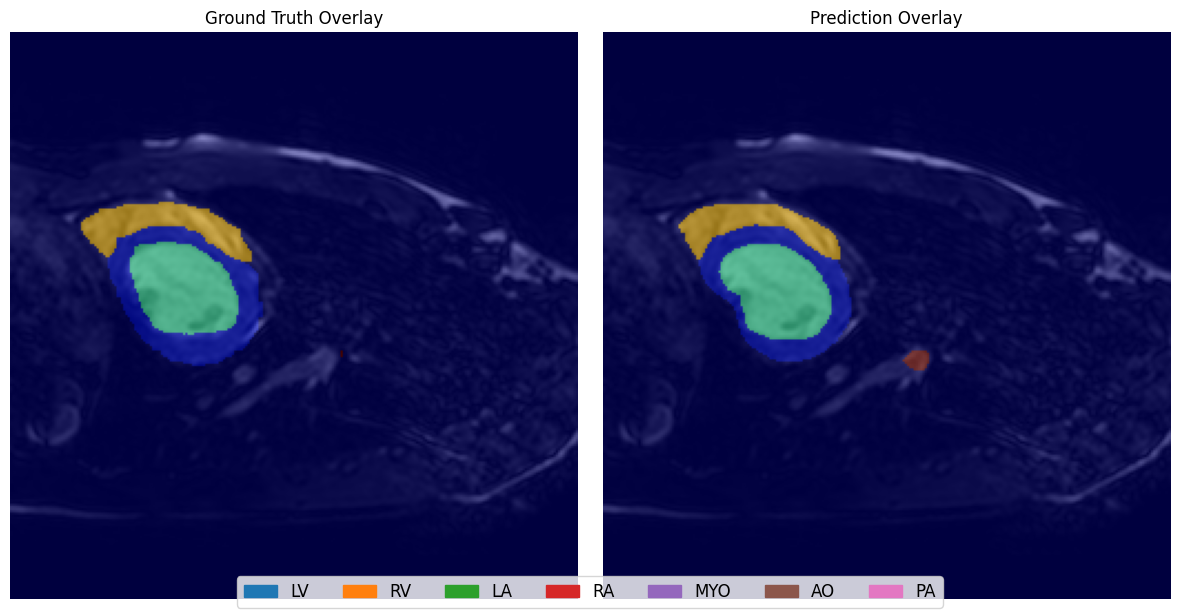

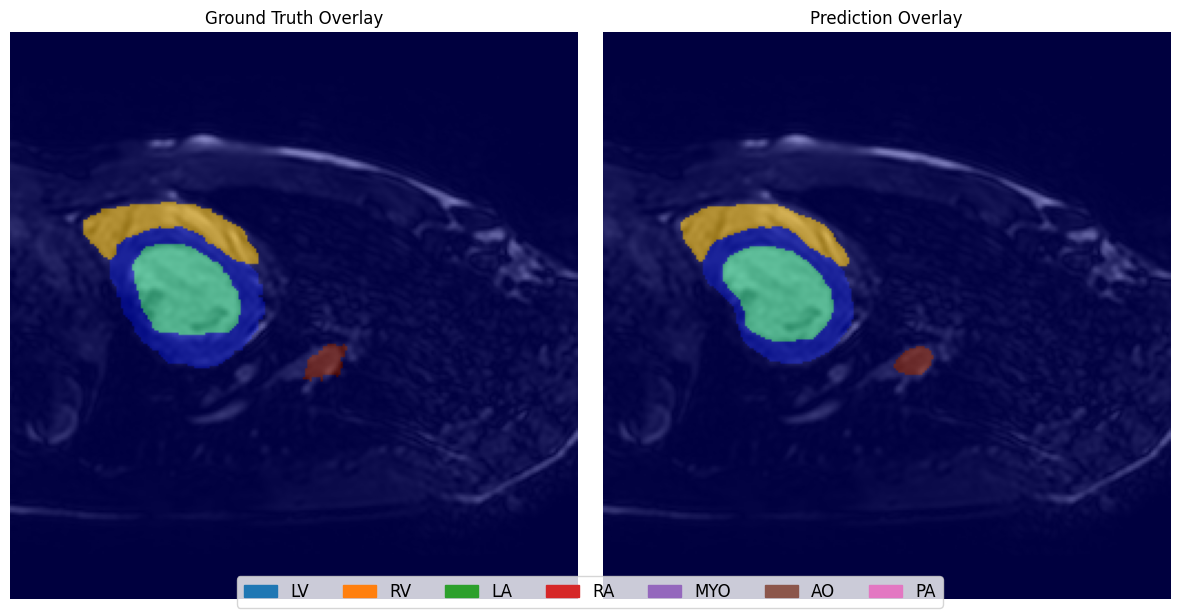

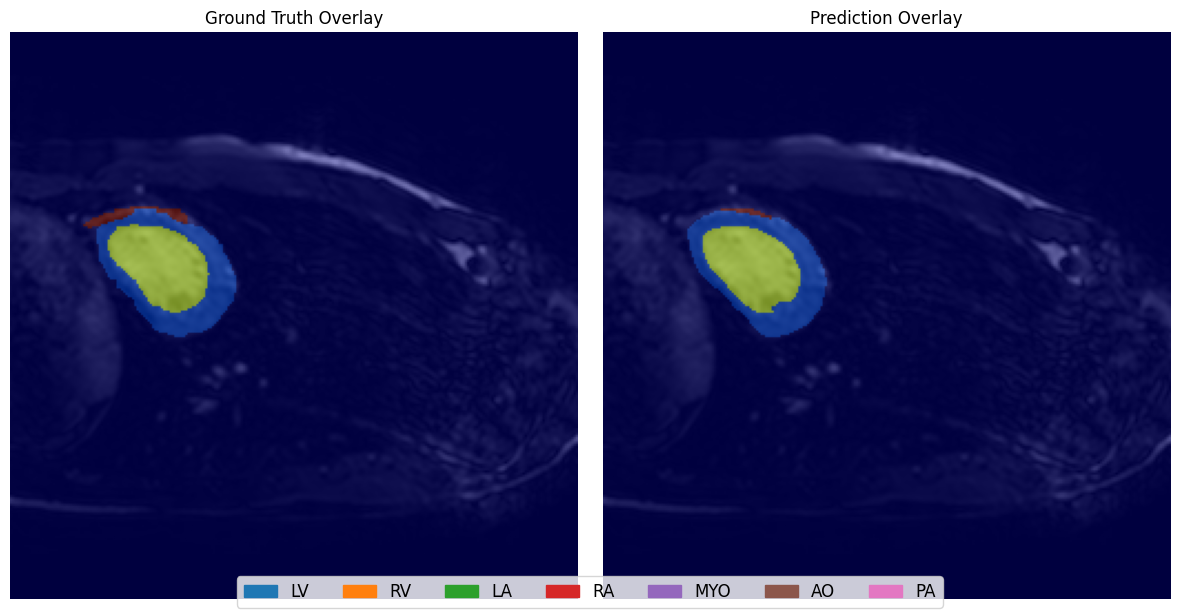

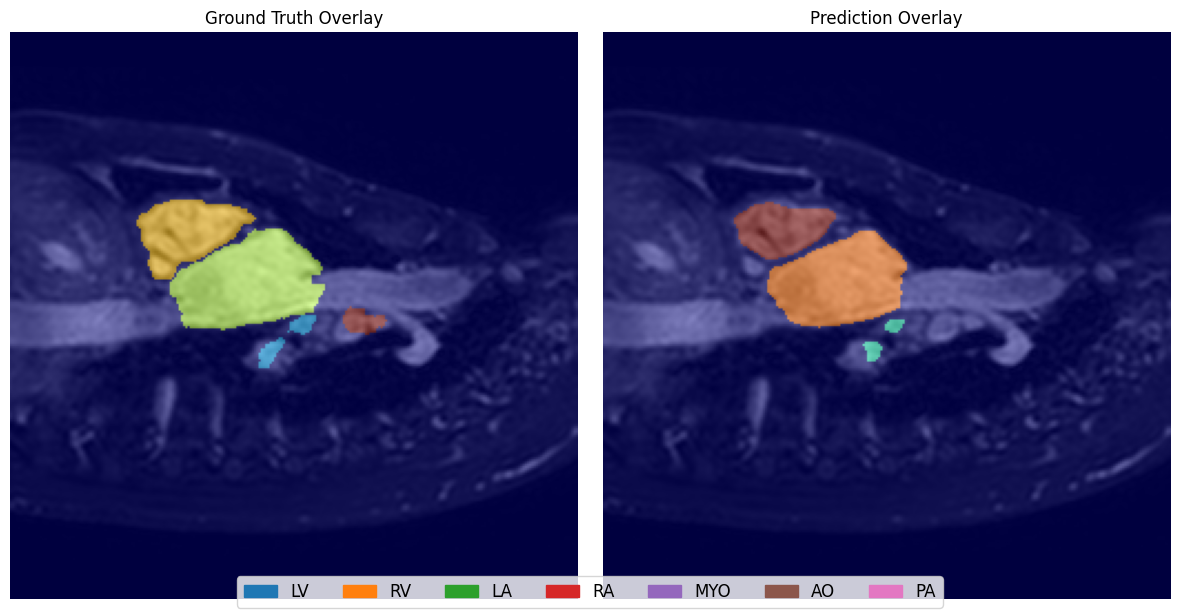

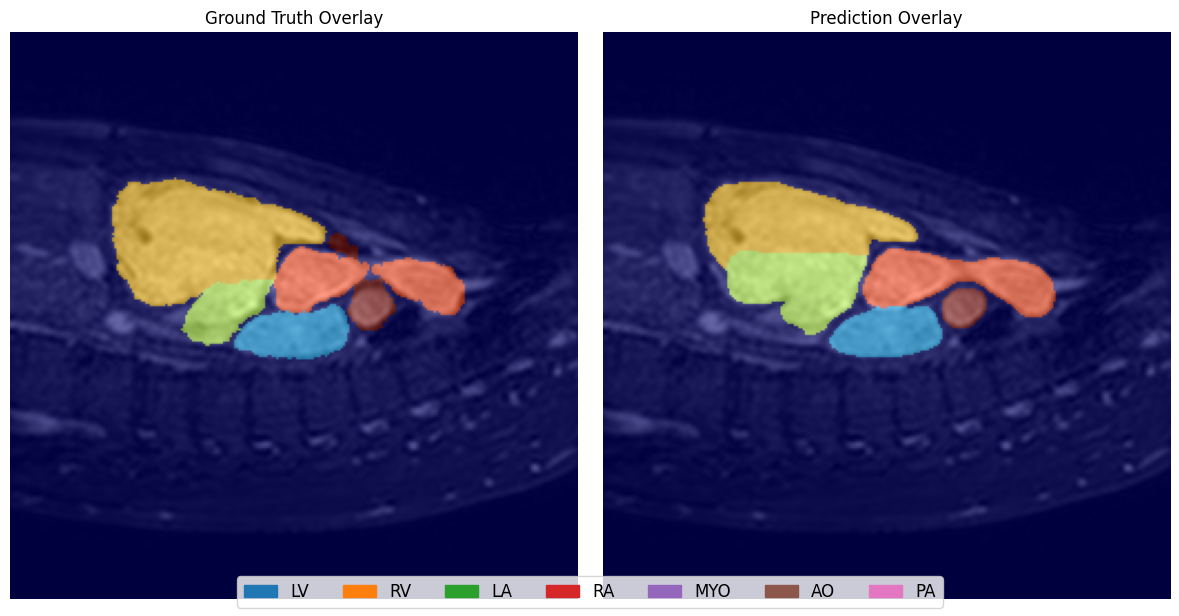

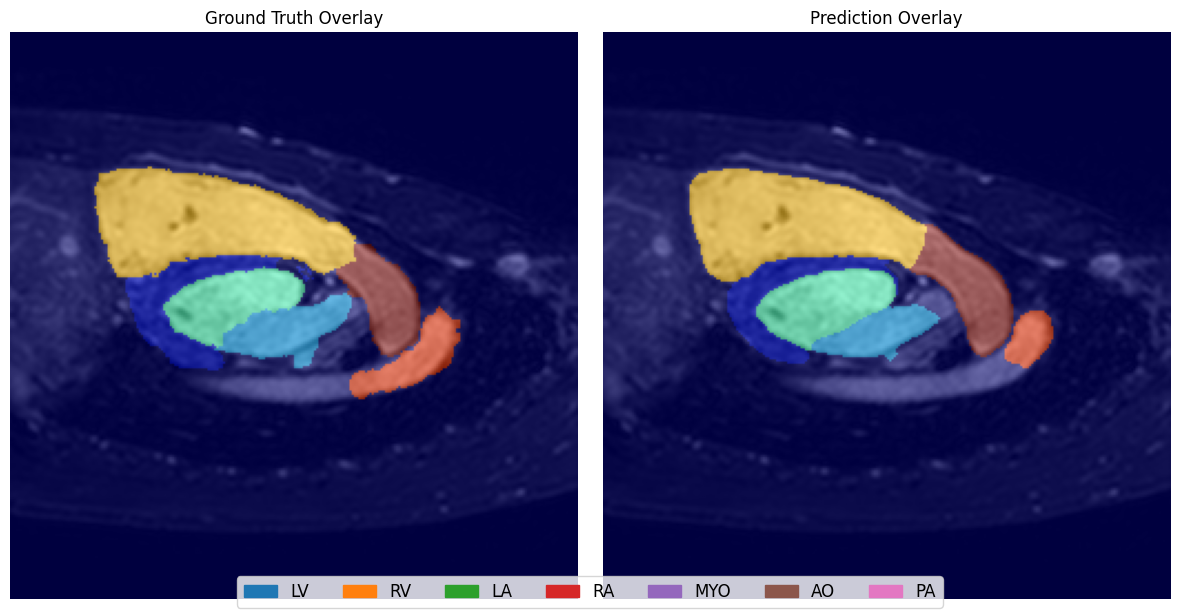

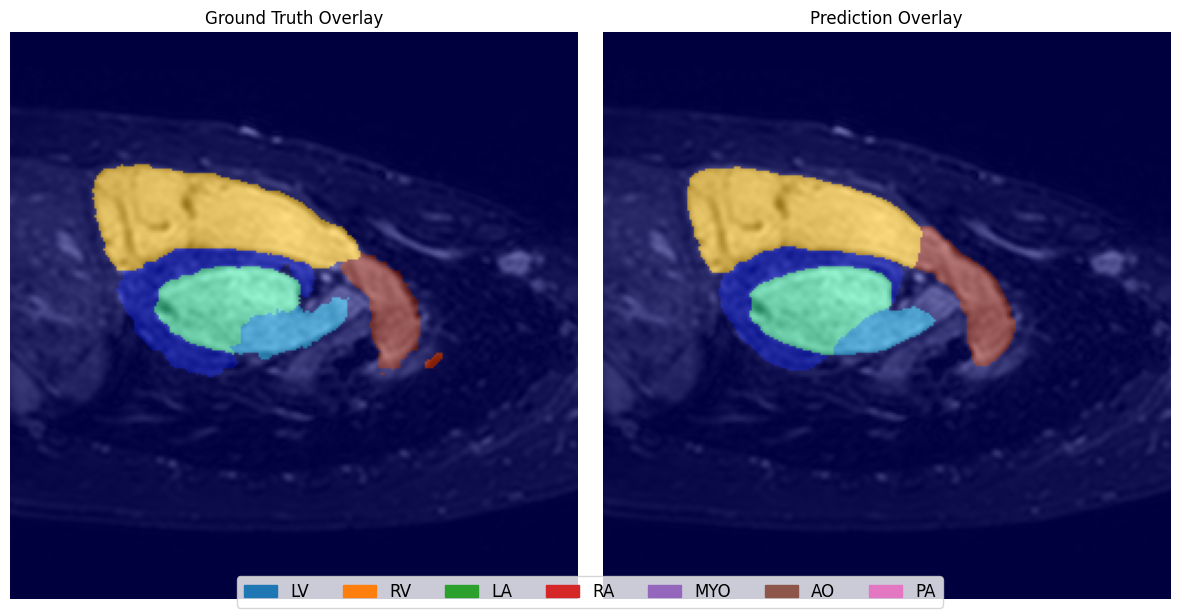

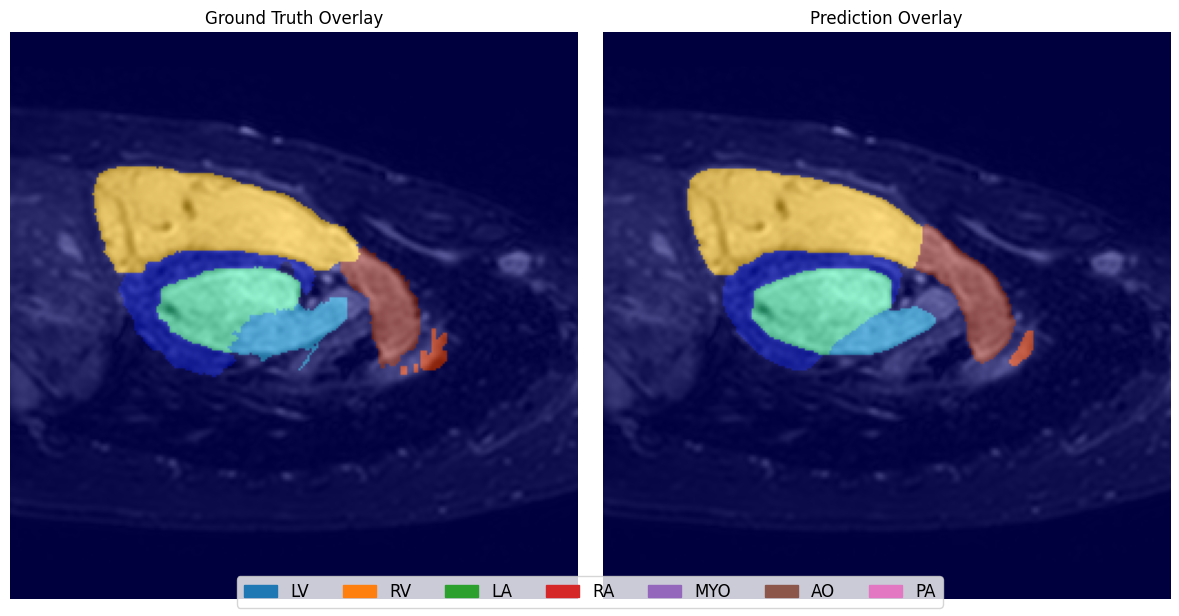

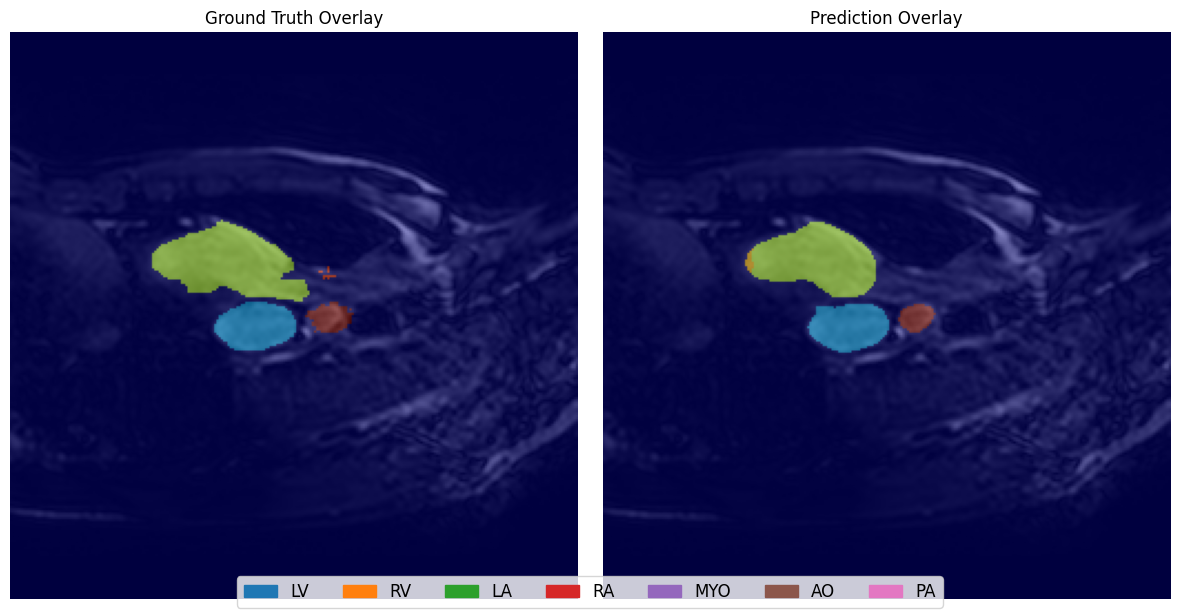

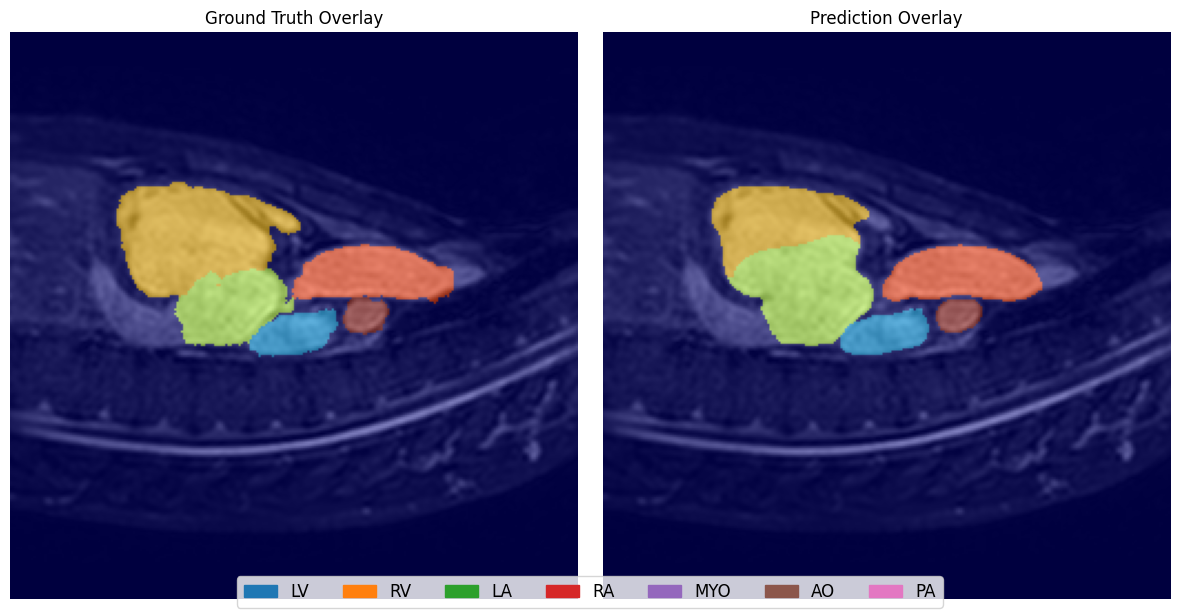

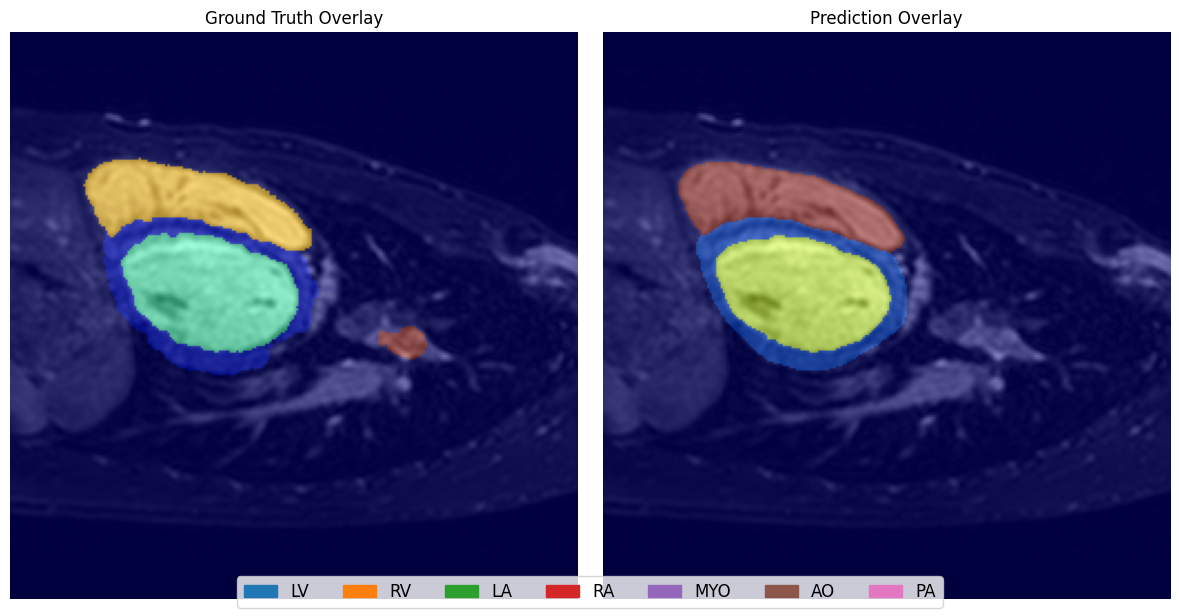

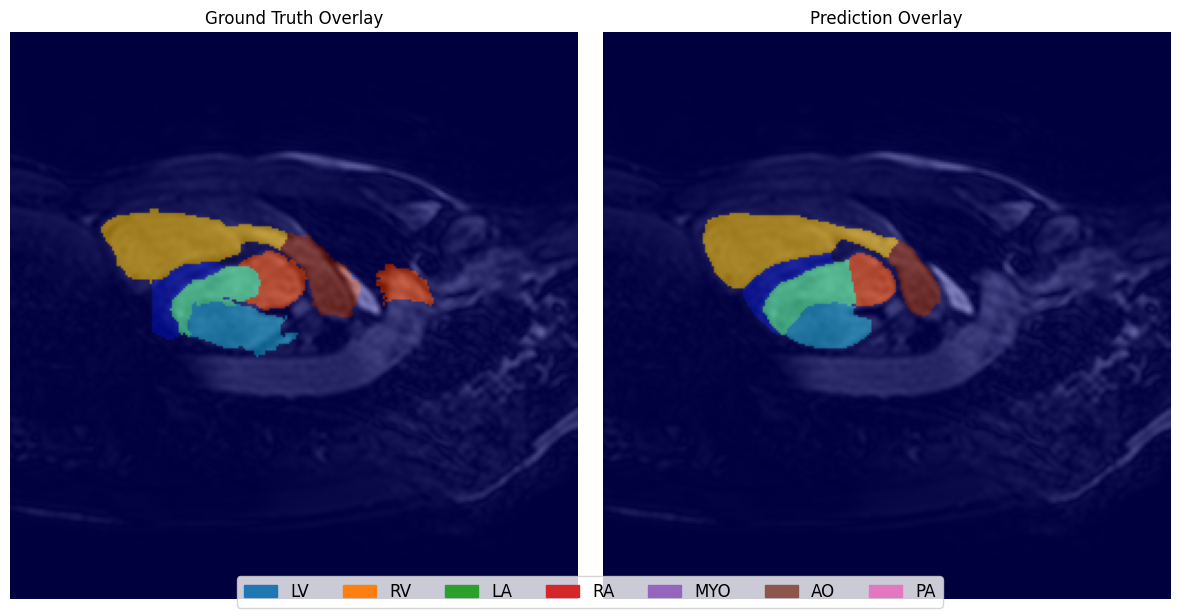

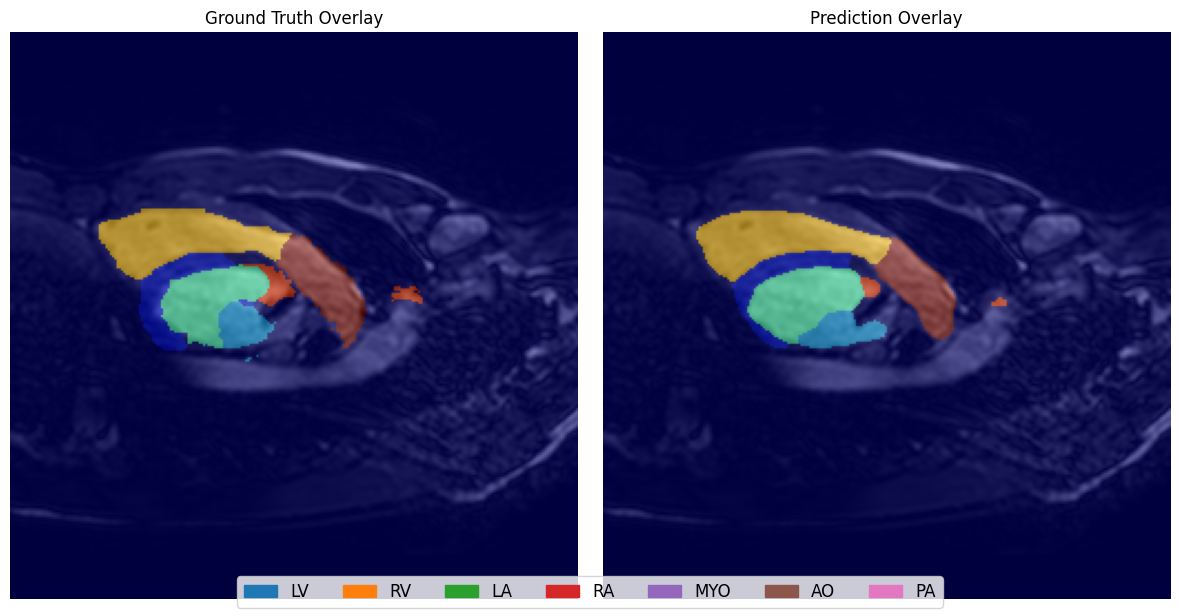

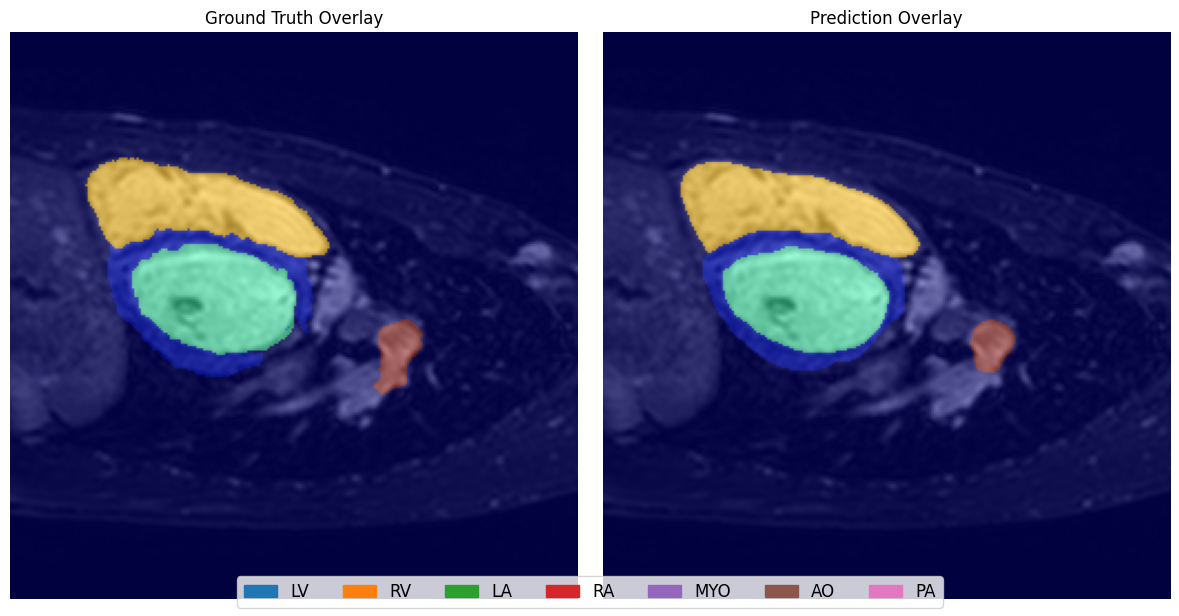

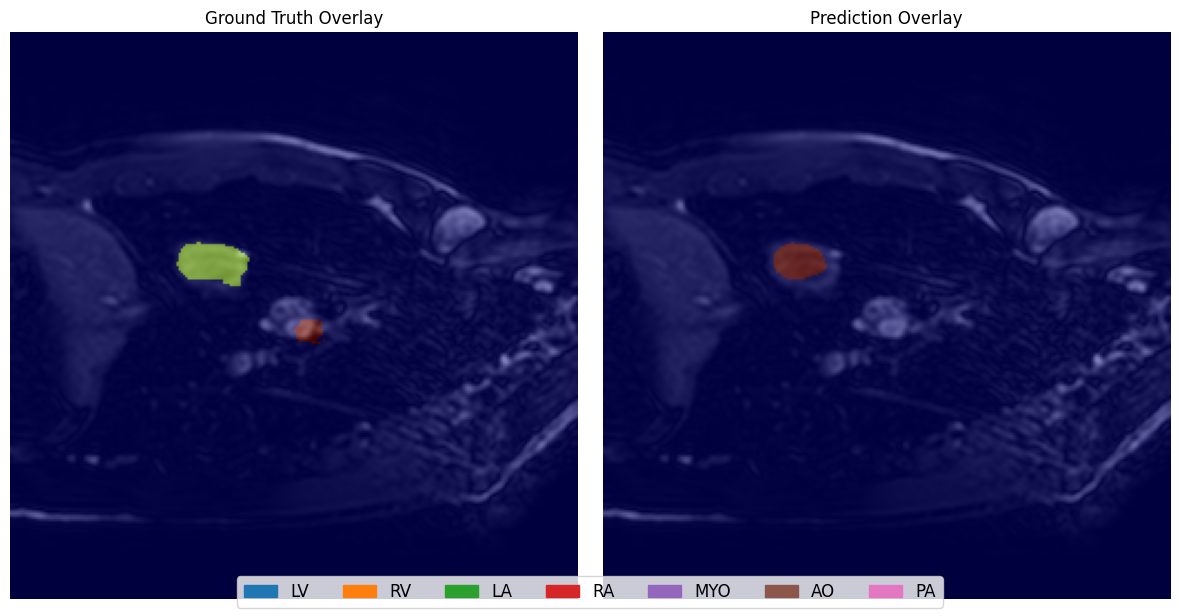

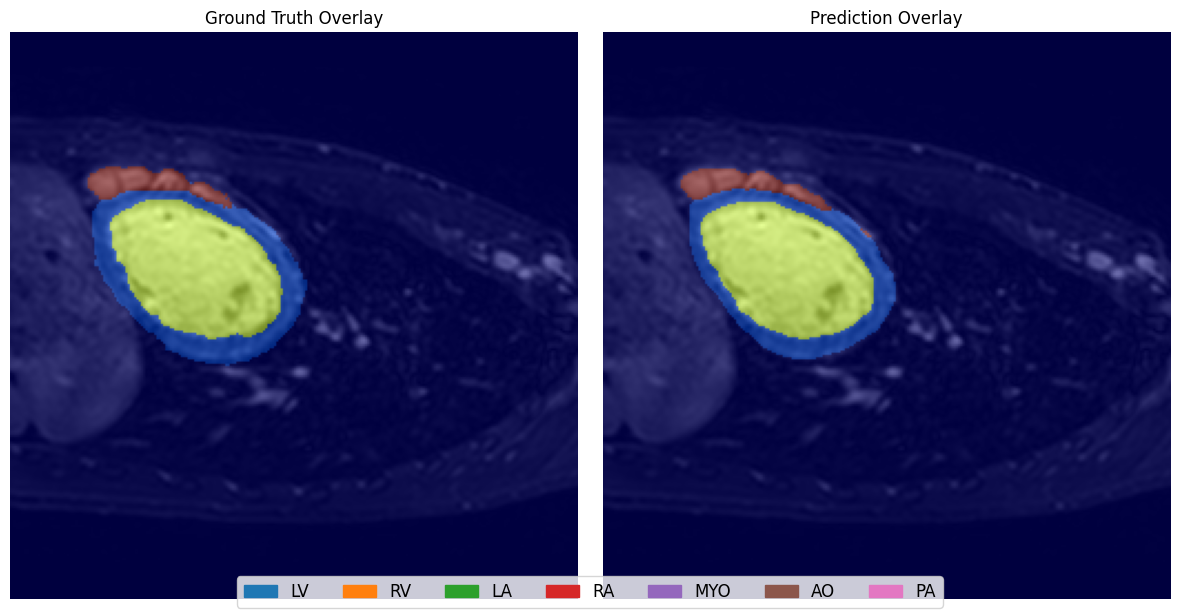

In [26]:
from scipy.stats import mode
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define class names (index 0 is Background)
class_names = ["Background", "LV", "RV", "LA", "RA", "MYO", "AO", "PA"]

def filter_attention(attn_map, seg_mask):
    """
    Zero out attention in background regions (where seg_mask == 0) and re-normalize.

    Parameters:
      attn_map: numpy array of shape [H, W] representing the attention map.
      seg_mask: numpy array of shape [H, W] representing the segmentation mask.
                (Assumes background label is 0.)

    Returns:
      filtered_attn: numpy array of shape [H, W] with background attention removed.
    """
    foreground_mask = (seg_mask > 0).astype(np.float32)
    filtered = attn_map * foreground_mask
    if filtered.max() > 0:
        filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min() + 1e-8)
    return filtered

print("Visualizing Validation Samples with Stacked Predictions and Filtered Attention (Baseline Model):")

# Ensure the best model is loaded.
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

num_val_samples = 20
val_sample_indices = random.sample(range(len(val_loader.dataset)), num_val_samples)
print("Visualizing Validation Samples:")

for idx in val_sample_indices:
    image, mask = val_loader.dataset[idx]  # image, mask: [1, 3, 256, 256]
    input_tensor = image.unsqueeze(1).to(device)  # [1, 1, 3, 256, 256]

    with torch.no_grad():
        output = model(input_tensor)  # [1, 8, 3, 256, 256]
        pred = torch.argmax(F.softmax(output, dim=1), dim=1).squeeze().cpu().numpy()  # [3, 256, 256]
    center_idx = pred.shape[0] // 2
    pred_slice = pred[center_idx]
    image_center = image.squeeze(0)[center_idx].cpu().numpy()
    mask_center = mask[center_idx].cpu().numpy()

    # Visualize without attention rollout since baseline model does not compute attention.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_center, cmap='gray')
    axs[0].imshow(mask_center, cmap='jet', alpha=0.5)
    axs[0].set_title("Ground Truth Overlay")
    axs[0].axis('off')

    axs[1].imshow(image_center, cmap='gray')
    axs[1].imshow(pred_slice, cmap='jet', alpha=0.5)
    axs[1].set_title("Prediction Overlay")
    axs[1].axis('off')

    # Create legend for foreground classes.
    color_list = [
        "#1f77b4",  # LV
        "#ff7f0e",  # RV
        "#2ca02c",  # LA
        "#d62728",  # RA
        "#9467bd",  # MYO
        "#8c564b",  # AO
        "#e377c2",  # PA
    ]
    patches = []
    # Legend only for foreground classes (ignoring background)
    for i, name in enumerate(class_names[1:]):
        patch = mpatches.Patch(color=color_list[i], label=name)
        patches.append(patch)
    plt.figlegend(handles=patches, loc='lower center', ncol=len(patches), labelspacing=0.5, fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
###########################################
# Visualization: Ground Truth vs. Prediction Overlay (Clean Inputs)
###########################################


Visualizing Test Samples with Stacked Predictions (Baseline Model):


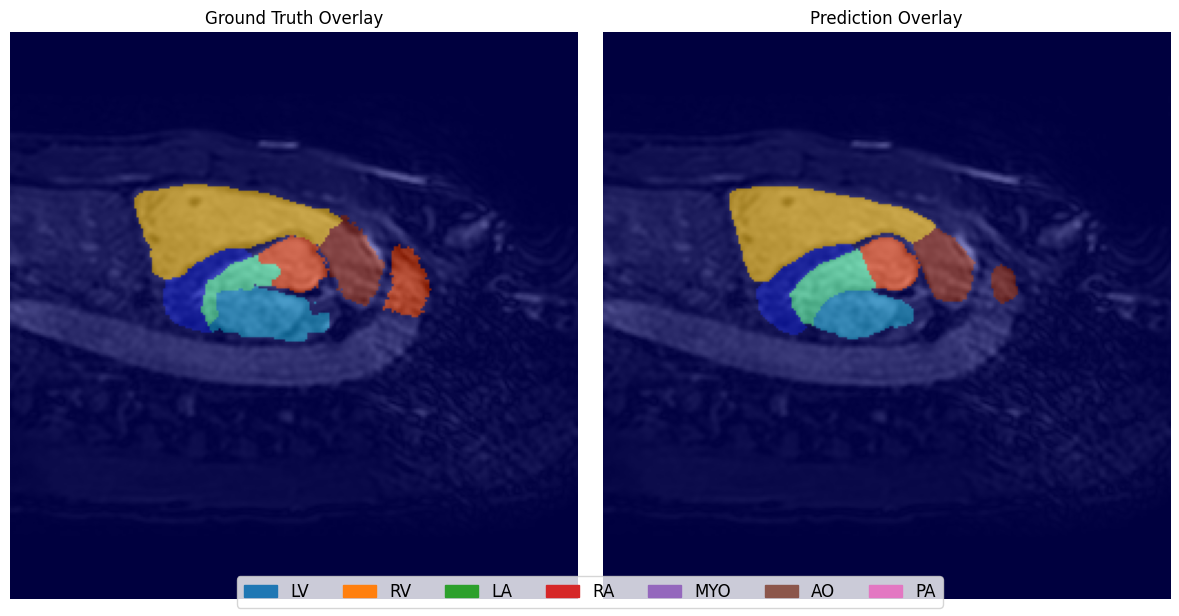

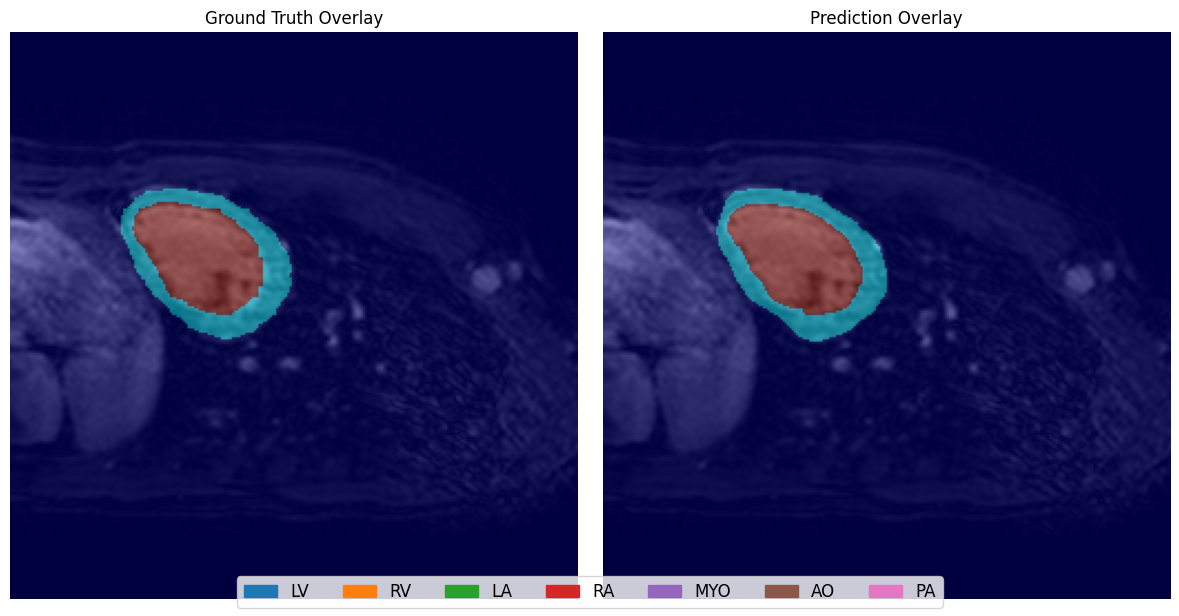

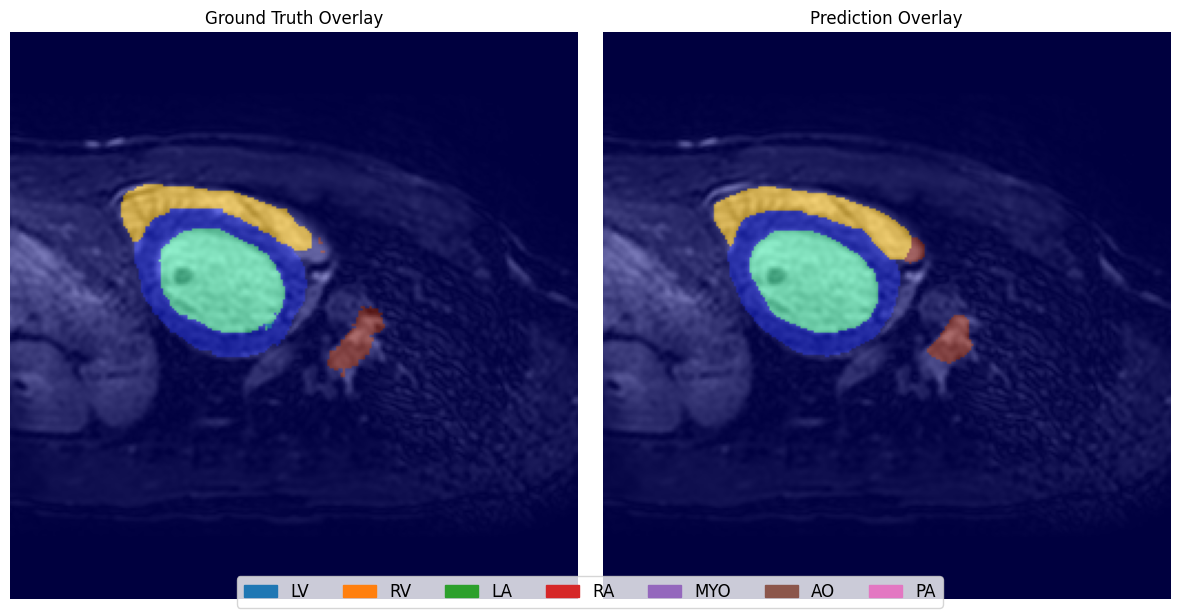

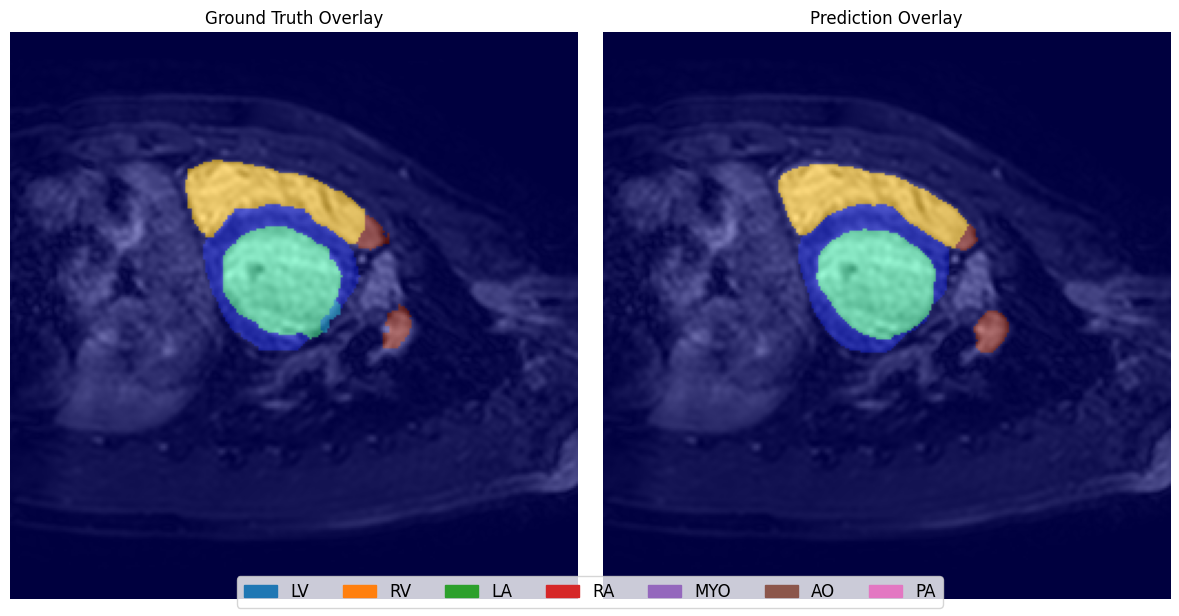

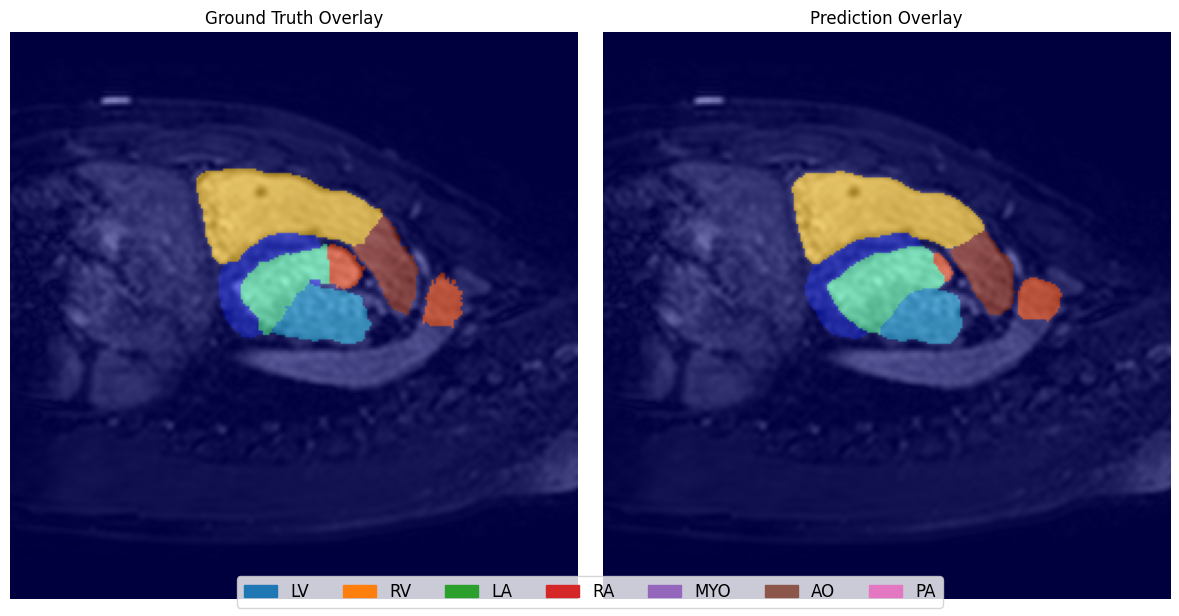

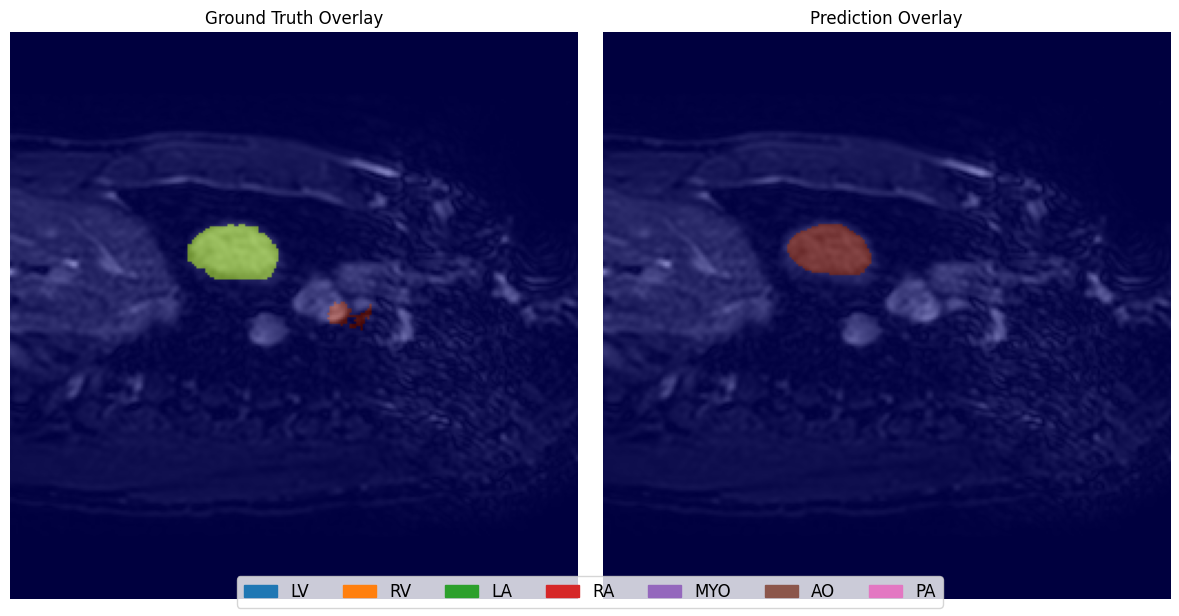

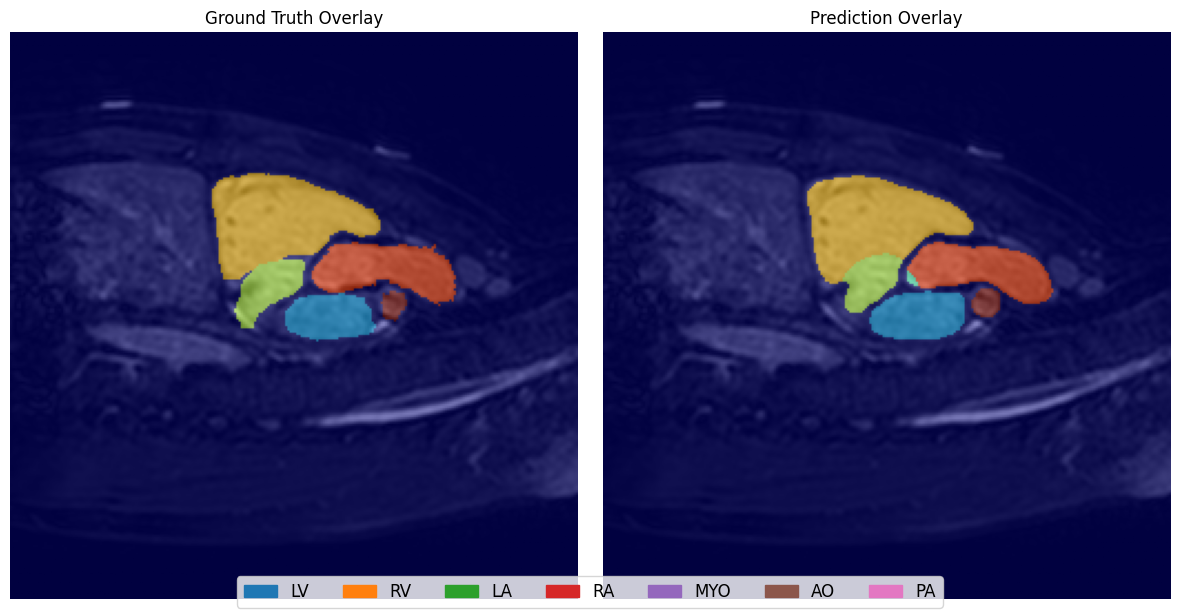

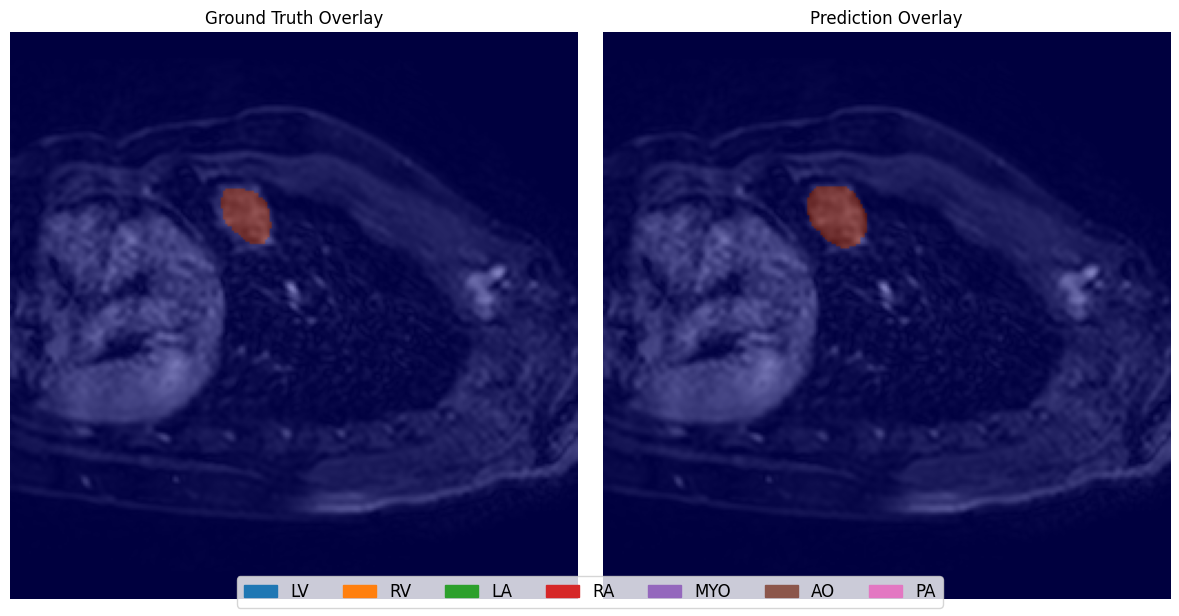

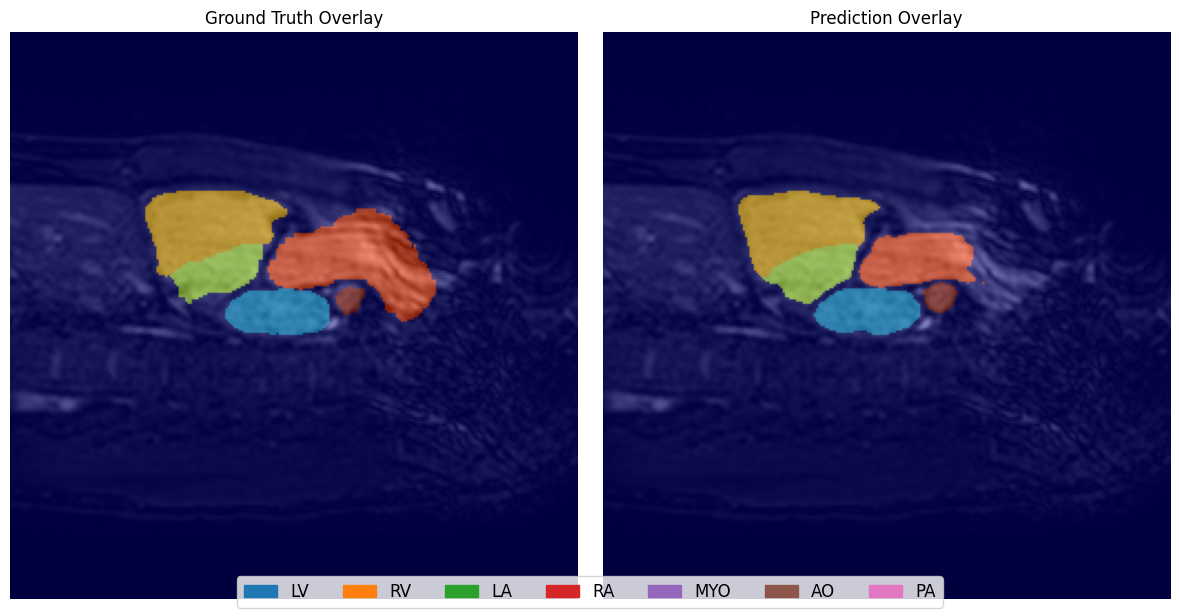

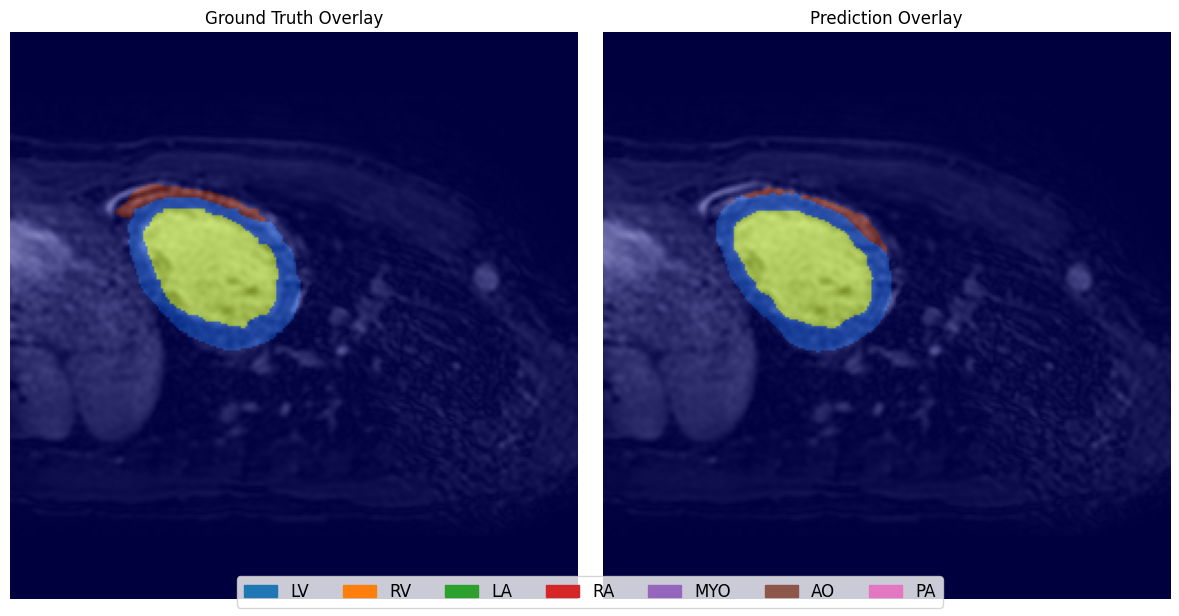

Validation Loss: 0.3101
Avg IoU (foreground only): 0.9113
Avg Dice (foreground only): 0.9533

Overall Test Dice: 0.9533, Test IoU: 0.9113


In [27]:

from scipy.stats import mode

print("\nVisualizing Test Samples with Stacked Predictions (Baseline Model):")

class TestDataset(StackedSliceDataset3D):
    pass

test_dir = '/content/drive/MyDrive/Colab Notebooks/Medical Imaging Project/pack/processed_data/mr_256/test/npz'
test_dataset = TestDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Load the best model checkpoint.
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

num_test_samples = 10
test_sample_indices = random.sample(range(len(test_dataset)), num_test_samples)

for idx in test_sample_indices:
    image, mask = test_dataset[idx]  # image, mask: [1, 3, 256, 256]
    input_tensor = image.unsqueeze(1).to(device)  # [1, 1, 3, 256, 256]

    with torch.no_grad():
        output = model(input_tensor)  # [1, 8, 3, 256, 256]
        pred = torch.argmax(F.softmax(output, dim=1), dim=1).squeeze().cpu().numpy()  # [3, 256, 256]

    # Aggregate predictions via majority voting.
    pred_stacked = mode(pred, axis=0)[0].squeeze()  # [256, 256]

    # For visualization, use the center slice (index 1) for input and ground truth.
    center_idx = 1
    input_center = image.squeeze(0)[center_idx].cpu().numpy()
    gt_center = mask[center_idx].cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(input_center, cmap='gray')
    axs[0].imshow(gt_center, cmap='jet', alpha=0.5)
    axs[0].set_title("Ground Truth Overlay")
    axs[0].axis('off')

    axs[1].imshow(input_center, cmap='gray')
    axs[1].imshow(pred_stacked, cmap='jet', alpha=0.5)
    axs[1].set_title("Prediction Overlay")
    axs[1].axis('off')

    # Create legend for foreground classes.
    patches = []
    for i, name in enumerate(class_names[1:]):
        patch = mpatches.Patch(color=color_list[i], label=name)
        patches.append(patch)
    plt.figlegend(handles=patches, loc='lower center', ncol=len(patches), labelspacing=0.5, fontsize=12)

    plt.tight_layout()
    plt.show()

# Evaluate the entire test set.
test_dice, test_iou = validate_model(model, criterion, test_loader, len(class_names), device)
print(f"\nOverall Test Dice: {test_dice:.4f}, Test IoU: {test_iou:.4f}")


Results and Visualization Plotting

In [ ]:
def test_dice_per_class(model, loader, num_classes, device):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)  # [B, num_classes, 3, 256, 256]
            preds = outputs.cpu().numpy().argmax(axis=1)  # [B, 3, 256, 256]
            gt = masks.cpu().numpy()  # [B, 3, 256, 256]
            conf_matrix += calculate_confusion_matrix(preds, gt, num_labels=num_classes)
    # Calculate dice score for each class
    dice_scores = calculate_dice(conf_matrix)
    return dice_scores

# Assume test_loader, model, and class_names (including background as first element) are defined.
# For example, if you have 8 classes:
num_classes = 8
dice_per_class = test_dice_per_class(model, test_loader, num_classes, device)

print("Dice per class on Test Set:")
for i, d in enumerate(dice_per_class):
    print(f"{class_names[i]}: {d:.4f}")


Dice per class on Test Set:
Background: 0.9912
LV: 0.8838
RV: 0.9494
LA: 0.9201
RA: 0.9193
MYO: 0.6783
AO: 0.7731
PA: 0.7390
